# ETP model : 

 - E (experience): customer may get better sense among parameters and car price  
 - T (task)      : Predict car price 
 - P (performance) : number of car price correctly predicted 
 


# Process :
    - DATA PREPROCESS 
    - SELECT MODELS 
    - FEATURE ENGINEERING 
    - PREDICTION ENSEMBLE 

#  Model :  
    - GROUP A : LINEAR + SVR
    - GROUP B : LINEAR + DECISION TREE (RANDOM FOREST)
    
# Ref :


- https://www.kaggle.com/orgesleka/used-cars-database
- https://www.slideshare.net/changecandy/cm-kaggletw-share


# =========================================================

In [1]:
# Load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# * 1 ) Data Preprocess 

In [50]:
# load car csv 

df = pd.read_csv('/Users/yennanliu/Desktop/used-cars-database/autos.csv' ,encoding = "ISO-8859-1" )

In [51]:
df = df.drop(['nrOfPictures','postalCode','abtest'], axis=1)

- Drop columns :  nrOfPictures, postalCode, abtest 
   - nrOfPictures  are all 0 
   - postalCode is not related to car price apparently
   - abtest has no description

In [52]:
df = df[(df.price < 150000) & (df.price > 100) ]

- Drop extreme big / small / unusual price data points

In [53]:
df = df[(df.yearOfRegistration > 1900) & (df.yearOfRegistration < 2016) ]

- Remove no sense yearOfRegistration data points , > 1900 for possible earlist register time, and < 2016 based on lastSeen column

In [54]:
df = df[(df.powerPS > 50) & (df.powerPS < 1000) ]

- Cleaning up the powerPS

In [55]:
# transform string to timestamp 

df.dateCrawled = pd.to_datetime(df.dateCrawled)
df.dateCreated = pd.to_datetime(df.dateCreated)
df.lastSeen = pd.to_datetime(df.lastSeen)

In [56]:
# create new feature : "time_online" by differences in days among lastseen and datesreated

df['time_online'] = (df.lastSeen - df.dateCreated).apply(lambda x: int(x.days))

- time_online :  how long such car object exist on ebay website

In [57]:
#max(df.dateCrawled)

In [58]:
# CHECK features correlation

corr = df.corr()
corr.loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.577832
kilometer              0.446202
yearOfRegistration     0.425019
time_online            0.127058
monthOfRegistration    0.042432
Name: price, dtype: float64

In [61]:
#plot_correlation_map(df)

In [11]:
selected_feature = ['price',
                    'powerPS',
                    'kilometer',
                    'yearOfRegistration',
                    'time_online']
                    #'monthOfRegistration']

In [12]:
selected_feature

['price', 'powerPS', 'kilometer', 'yearOfRegistration', 'time_online']

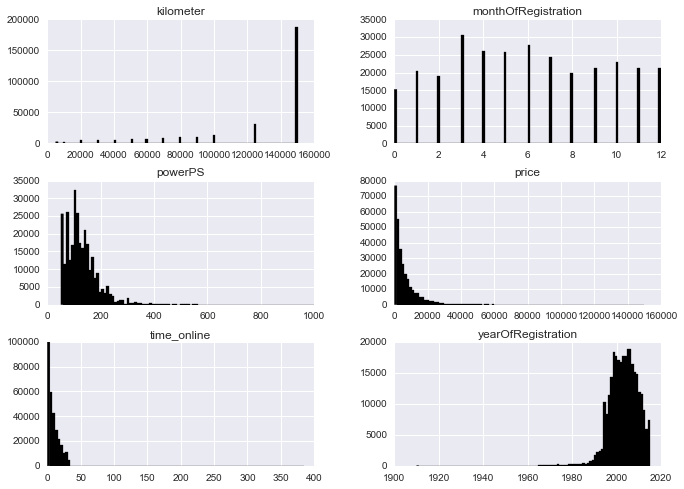

In [13]:
#df_train.info()
df.hist(bins=100, figsize=(11,8),color='black')
plt.show()

##  After data preprocess,  get prepared data sample :  


In [14]:
print ('car sample counts :' , len(df))
print ('seleceted feature :' , selected_feature)

car sample counts : 295345
seleceted feature : ['price', 'powerPS', 'kilometer', 'yearOfRegistration', 'time_online']


# * 2)  SELECT MODELS
    - Linear 
    - SVR
    - Decision tree
    - Random forest

###  Before first run model, we need to split data set into TRAIN and TEST group for evaluate prediction accuracy ahead really given test 

In [66]:
#  help function 

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error


def sample_split(data):
    #data =  data[selected_feature]
    relevent_cols = list(data)
    autos=data.values.astype(float)             
    Y = autos[:,0]
    X = autos[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test


def reg_analysis(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    #Calculate Variance score
    Variance_score = explained_variance_score(y_test, prediction)
    print ('Variance score : %.2f' %Variance_score)
    #Mean Absolute Error
    MAE = mean_absolute_error(y_test, prediction)
    print ('Mean Absolute Error : %.2f' %MAE)
    #Root Mean Squared Error
    RMSE = mean_squared_error(y_test, prediction)**0.5
    print ('Mean Squared Error : %.2f' %RMSE)
    #R² score, the coefficient of determination
    r2s = r2_score(y_test, prediction)
    print ('R2  score : %.2f' %r2s)
    return model
    

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

In [16]:
X_train, X_test, y_train, y_test = sample_split(df[selected_feature])

In [17]:
#df[selected_feature]

In [18]:
# Linear model 

from sklearn import linear_model

model = linear_model.LinearRegression()
print ('Linear Regression')
reg_analysis(model,X_train, X_test, y_train, y_test)

Linear Regression
Variance score : 0.55
Mean Absolute Error : 3146.14
Mean Squared Error : 5462.58
R2  score : 0.55


//anaconda/envs/g_dash/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [19]:
# only grab 2953 minor dataset for fast run SVR 

df_sample = df.sample(frac=0.1, replace=True).reset_index()
df_sample

X_train_, X_test_, y_train_, y_test_ = sample_split(df_sample[selected_feature])

In [125]:
# SVR

from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

model = SVR(kernel='rbf', C=1e3, gamma=0.1)
print ('SVR')
reg_analysis(model,X_train_, X_test_, y_train_, y_test_)

SVR
Variance score : 0.29
Mean Absolute Error : 3226.24
Mean Squared Error : 7191.76
R2  score : 0.24


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
# SVR

from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

model = SVR(kernel='rbf', C=1e3, gamma=0.1)
print ('SVR')
reg_analysis(model,X_train, X_test, y_train, y_test)

SVR


In [23]:
# SVR

#from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

from sklearn.svm import LinearSVR

model = LinearSVR()
print ('SVR')
reg_analysis(model,X_train, X_test, y_train, y_test)

SVR
Variance score : 0.39
Mean Absolute Error : 4321.86
Mean Squared Error : 6550.08
R2  score : 0.36


In [24]:
# Decision tree

from sklearn import tree

model = tree.DecisionTreeClassifier()
print ('Decision tree')
reg_analysis(model,X_train, X_test, y_train, y_test)

Decision tree
Variance score : 0.60
Mean Absolute Error : 2346.99
Mean Squared Error : 5242.27
R2  score : 0.59


In [25]:
### using RandomForestRegressor instead of RandomForestClassifier model 
# https://www.quora.com/What-is-the-difference-between-scikit-learns-random-forest-classifier-and-random-forest-regressor


# Random forest 
#from sklearn.ensemble import RandomForestClassifier 
#model = RandomForestClassifier()
#print ('Random forest')
#reg_analysis(model,X_train_, X_test_, y_train_, y_test_)

In [63]:
# Random forest 

from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor()
print ('Random forest')
reg_analysis(model,X_train, X_test, y_train, y_test)

Random forest
Variance score : 0.81
Mean Absolute Error : 1611.85
Mean Squared Error : 3556.42
R2  score : 0.81


# * 3) FEATURE ENGINEERING  

In [27]:
last_seen =  max(df.lastSeen)
last_seen

Timestamp('2016-04-07 14:58:51')

In [28]:
#df.head(3)

In [29]:
# create new feature : "car_age" , how old car is 

df['car_age'] =  (last_seen.year - df.yearOfRegistration).apply(lambda x: int(x))

In [30]:
# Transform non-value columns to numerical features by dummy variables 

# Dummy Variables
# https://chrisalbon.com/python/pandas_convert_categorical_to_dummies.html

df_fuel_type =  pd.get_dummies(df['fuelType'])
df_gear_box =  pd.get_dummies(df['gearbox'])
df_vehicleType =  pd.get_dummies(df['vehicleType'])
df_ = pd.concat([df, df_fuel_type,df_gear_box,df_vehicleType], axis=1)

In [31]:
df_intermediate  = df_[selected_feature]


# normalize
df_norm = (df_intermediate - df_intermediate.mean()) / (df_intermediate.max() - df_intermediate.min())


# standardize
df_std = (df_intermediate - df_intermediate.mean()) / df_intermediate.std()

In [32]:
#df_.columns

In [33]:
selected_feature_updated = [ 'price', 'yearOfRegistration', 'powerPS','kilometer',
       'monthOfRegistration','time_online','car_age',
       'andere', 'benzin', 'cng', 'diesel', 'elektro', 'hybrid', 'lpg',
       'automatik', 'manuell', 'andere', 'bus', 'cabrio', 'coupe',
       'kleinwagen', 'kombi', 'limousine', 'suv']

In [34]:
# re-run model with new featured dataset 

X_train, X_test, y_train, y_test = sample_split(df_[selected_feature_updated])

In [35]:
# Linear model 

model = linear_model.LinearRegression()
print ('Linear Regression')
reg_analysis(model,X_train, X_test, y_train, y_test)

Linear Regression
Variance score : 0.58
Mean Absolute Error : 3085.81
Mean Squared Error : 5271.19
R2  score : 0.58


In [36]:
# linear SVR

from sklearn.svm import LinearSVR

model = LinearSVR()
print ('SVR')
reg_analysis(model,X_train, X_test, y_train, y_test)

SVR
Variance score : 0.37
Mean Absolute Error : 4510.93
Mean Squared Error : 6725.13
R2  score : 0.32


In [37]:
# Decision tree

model = tree.DecisionTreeClassifier()
print ('Decision tree')
reg_analysis(model,X_train, X_test, y_train, y_test)

Decision tree
Variance score : 0.62
Mean Absolute Error : 2068.30
Mean Squared Error : 5021.45
R2  score : 0.62


In [67]:
# Random forest 

from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor()
print ('Random forest')
RandomForestRegressor_model = reg_analysis(model,X_train, X_test, y_train, y_test)

Random forest
Variance score : 0.81
Mean Absolute Error : 1612.56
Mean Squared Error : 3559.59
R2  score : 0.81


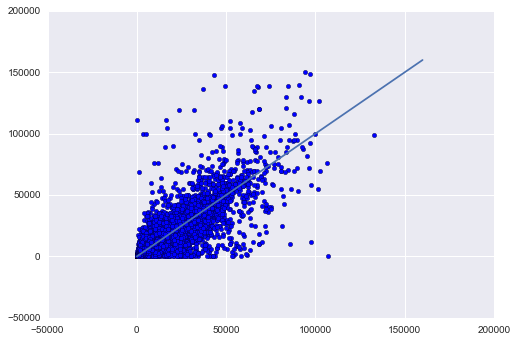

In [100]:
#plt(y=x)
x = range(0,160000)
y = range(0,160000)
plt.plot(x, y)
scatter(RandomForestRegressor_model.predict(X_test),y_test)

# =================

In [39]:
#plt.scatter(df_['yearOfRegistration'],df_['price'])

In [40]:
#sns.pairplot(df[:100], hue="brand")

In [41]:
#df_[['brand']] #.columns

In [101]:
df_.head()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,...,automatik,manuell,andere,bus,cabrio,coupe,kleinwagen,kombi,limousine,suv
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,coupe,2011,manuell,190,NaN,...,0,1,0,0,0,1,0,0,0,0
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,suv,2004,automatik,163,grand,...,1,0,0,0,0,0,0,0,0,1
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,kleinwagen,2001,manuell,75,golf,...,0,1,0,0,0,0,1,0,0,0
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,kleinwagen,2008,manuell,69,fabia,...,0,1,0,0,0,0,1,0,0,0
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,limousine,1995,manuell,102,3er,...,0,1,0,0,0,0,0,0,1,0


In [43]:
#df_.info()

# * 4) PREDICTION ENSEMBLE 

####  GROUP A : LINEAR + SVR

In [102]:
# Linear model 

model = linear_model.LinearRegression()
print ('Linear Regression')
linear_model =  reg_analysis(model,X_train, X_test, y_train, y_test)

Linear Regression
Variance score : 0.58
Mean Absolute Error : 3085.81
Mean Squared Error : 5271.19
R2  score : 0.58


In [103]:
# SVR

#from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

from sklearn.svm import LinearSVR

model = LinearSVR()
print ('SVR')
SVR_model = reg_analysis(model,X_train, X_test, y_train, y_test)

SVR
Variance score : 0.41
Mean Absolute Error : 5222.14
Mean Squared Error : 7229.05
R2  score : 0.22


In [116]:
linear_prediction = linear_model.predict(X_test)
SVR_prediction = SVR_model.predict(X_test)
group_A_predict = (linear_prediction+SVR_prediction)/2

In [115]:
Variance_score = explained_variance_score(y_test, group_A_predict)
print ('Variance score : %.2f' %Variance_score)
#Mean Absolute Error
MAE = mean_absolute_error(y_test, group_A_predict)
print ('Mean Absolute Error : %.2f' %MAE)
#Root Mean Squared Error
RMSE = mean_squared_error(y_test, group_A_predict)**0.5
print ('Mean Squared Error : %.2f' %RMSE)
#R² score, the coefficient of determination
r2s = r2_score(y_test, group_A_predict)
print ('R2  score : %.2f' %r2s)

Variance score : 0.54
Mean Absolute Error : 3722.57
Mean Squared Error : 5824.84
R2  score : 0.49


####  GROUP B : LINEAR + DECISION TREE (RANDOM FOREST)

In [119]:
# Random forest 

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
print ('Random forest')
RandomForestRegressor_model = reg_analysis(model,X_train, X_test, y_train, y_test)

Random forest
Variance score : 0.81
Mean Absolute Error : 1608.75
Mean Squared Error : 3550.20
R2  score : 0.81


In [120]:
linear_prediction = linear_model.predict(X_test)
RandomForestRegressor_prediction = RandomForestRegressor_model.predict(X_test)
group_B_predict = (linear_prediction+RandomForestRegressor_prediction)/2

In [121]:
Variance_score = explained_variance_score(y_test, group_B_predict)
print ('Variance score : %.2f' %Variance_score)
#Mean Absolute Error
MAE = mean_absolute_error(y_test, group_B_predict)
print ('Mean Absolute Error : %.2f' %MAE)
#Root Mean Squared Error
RMSE = mean_squared_error(y_test, group_B_predict)**0.5
print ('Mean Squared Error : %.2f' %RMSE)
#R² score, the coefficient of determination
r2s = r2_score(y_test, group_B_predict)
print ('R2  score : %.2f' %r2s)

Variance score : 0.77
Mean Absolute Error : 2068.25
Mean Squared Error : 3930.33
R2  score : 0.77
